<a href="https://colab.research.google.com/github/Sultan477/DataScience/blob/main/PySpark_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pandas - одна из наиболее используемых библиотек Python с открытым исходным кодом для работы со структурированными табличными данными для анализа. Однако он не поддерживает распределенную обработку, поэтому вам всегда придется увеличивать ресурсы, когда вам понадобится дополнительная мощность для поддержки растущих данных. И всегда наступит момент, когда ресурсов станет недостаточно. В данной статье мы рассмотрим, как PySpark выручает в условиях нехватки мощностей для обработки данных.

Ну что же, приступим. Для начала скачаем необходимые наборы данных с kaggle. Инструкция по скачиванию данных в colab напрямую с kaggle ниже:

1. Заходим в раздел Account на [kaggle.com](https://www.kaggle.com/)

2. Пролистываем вниз до подраздела API

3. Жмем кнопку Create New API Token, скачиваем файл kaggle.json

4. Далее этот файл можно сразу бросить в Files на Google Colab, но так как каждые 12 часов сессия Google Colab полностью обновляется, то я предпочитаю положить в директорию Colab Notebooks на Google Drive


(https://www.kaggle.com/general/74235) - инструкция подробнее



In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sultan477","key":"2b867d93dfb96d6eb0e338736e926cf8"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


Попробуем поэкспериментировать с датасетом [Riiid Answer Correctness Prediction](https://www.kaggle.com/competitions/riiid-test-answer-prediction/)

Код ниже скачивает датасет, все нужные файлы после этого лежат в папке data.



In [5]:
! pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/ # файл kaggle.json можно положить в любую папку в Drive, главное указать актуальный адрес в первом аргументе команды cp
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'riiid-test-answer-prediction'
! mkdir data
! unzip riiid-test-answer-prediction.zip -d data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.29G/1.29G [01:11<00:00, 27.5MB/s]
100% 1.29G/1.29G [01:11<00:00, 19.5MB/s]
Archive:  riiid-test-answer-prediction.zip
  inflating: data/example_sample_submission.csv  
  inflating: data/example_test.csv   
  inflating: data/lectures.csv       
  inflating: data/questions.csv      
  inflating: data/riiideducation/__init__.py  
  inflating: data/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: data/train.csv          


Датасет, скажем так, не огромный, и, возможно, ресурсов вашей машины вполне хватит и для работы с pandas. Поэтому я буду показывать пример на бесплатной версии Google Colab. В бесплатном режиме нам предоставлено не более 12 ГБ оперативной памяти и для нашего учебного случая это как раз то, что нужно.

Для начала попробуем проанализировать наш датасет с помощью библиотеки pandas.

1. Pandas

In [ ]:
import pandas as pd

df_train = pd.read_csv('data/train.csv',
                        dtype={'content_id': 'int16',
                               'content_type_id': 'int8',
                               'task_container_id': 'int16',
                               'user_answer': 'int8',
                               'answered_correctly': 'int8',
                               'prior_question_elapsed_time': 'float32'})

Взглянем на наши данные

In [ ]:
df_train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  object 
dtypes: float32(1), int16(2), int64(3), int8(3), object(1)
memory usage: 4.1+ GB


Как видим, данные нашей таблицы занимают чуть больше 4 ГБ оперативной памяти, что составляет примерно треть памяти, выделенной colab для нас.

Посмотрим, сколько в нашей таблице пустых значений.

In [ ]:
df_train.isna().sum()

,0
row_id,0
timestamp,0
user_id,0
content_id,0
content_type_id,0
task_container_id,0
user_answer,0
answered_correctly,0
prior_question_elapsed_time,2351538
prior_question_had_explanation,392506


In [ ]:
df_train[['prior_question_elapsed_time', 'prior_question_had_explanation']].isna().mean()

,0
prior_question_elapsed_time,0.023230
prior_question_had_explanation,0.003877


Имеем: в столбце prior_question_elapsed_time всего чуть более 2% пропусков, в prior_question_had_explanation и того меньше. Пробуем удалить их методом dropna библиотеки pandas и...

In [ ]:
df = df_train.dropna()

... получаем ошибку нехватки оперативной памяти.

Примечание. На самом деле, получить данную ошибку мы могли в самом начале, при чтении датасете. Для этого достаточно было бы применить метод read_csv с аргументами по-умолчанию. Тогда pandas присвоил бы каждому столбцу с числовыми данными либо тип int64, либо тип float64. А памяти они занимают немало...

Там, где не справился pandas, прибегнем к помощи pyspark.



2. Pyspark
Установим pyspark и pyarrow. Pyarrow значительно ускоряет работу pyspark, что в нашем случае очень пригодится

In [6]:
! pip install pyspark
! pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=8523872169796eac9f479a292180ea13a4ea9260d072bc9d4910997b921e9b5e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [7]:
from pyspark.sql import SparkSession
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1" # без этой строчки у нас будет возникать постоянное предупреждение с просьбой установить эту переменную в значение 1, что мы заранее и делаем


spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark

Давайте прочтем наш файл и посмотрим, какие колонки присутствуют в нашей таблице. Если мы уверены, что у нас в каждой колонке присутствует один конкретный тип данных, можно установить параметр inferSchema=True, pyspark самостоятельно определит типы для каждой колонки.

In [8]:
df = spark.read.csv('data/train.csv', header=True, inferSchema=True)

df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- content_id: integer (nullable = true)
 |-- content_type_id: integer (nullable = true)
 |-- task_container_id: integer (nullable = true)
 |-- user_answer: integer (nullable = true)
 |-- answered_correctly: integer (nullable = true)
 |-- prior_question_elapsed_time: double (nullable = true)
 |-- prior_question_had_explanation: boolean (nullable = true)



Для просмотра данных в pyspark есть метод show

In [9]:
df.show()

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|     0|        0|    115|      5692|              0|                1|          3|                 1|                       NULL|                          NULL|
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                         false|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                         false|
|     3|   131167|    115|  

Прежде, чем заниматься пропусками, необходимо привести данные столбца prior_question_had_explanation к целочисленному типу

In [10]:
from pyspark.sql.types import IntegerType

df = df.withColumn('prior_question_had_explanation', df['prior_question_had_explanation'].cast(IntegerType()))
df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- content_id: integer (nullable = true)
 |-- content_type_id: integer (nullable = true)
 |-- task_container_id: integer (nullable = true)
 |-- user_answer: integer (nullable = true)
 |-- answered_correctly: integer (nullable = true)
 |-- prior_question_elapsed_time: double (nullable = true)
 |-- prior_question_had_explanation: integer (nullable = true)



Посмотрим, сколько в нашей таблице пустых значений. Метод pandas_api преобразует существующий DataFrame в pandas-on-Spark DataFrame (это доступно только в том случае, если pandas установлен и доступен).

In [11]:
df.pandas_api().isna().mean() # выведем процентное соотношение

row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       0.023230
prior_question_had_explanation    0.003877
dtype: float64

На этот раз удалить пропущенные данные удается без проблем.



In [12]:
df = df.dropna()
df.pandas_api().isna().sum()

row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

Теперь рассмотрим как с помощью pyspark можно вывести на экран матрицу корреляции.

Матрица корреляции.
Метод corr класса Correlation работает только с векторными столбцами. Поэтому прежде создания корреляционной матрицы необходимо применить преобразование датасета с помощью [VectorAssembler](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html)

> Из [документации](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.stat.Correlation.html): column - имя столбца векторов, для которого необходимо вычислить коэффициент корреляции. Это должен быть столбец набора данных, и он должен содержать <u> объекты Vector</u>.



In [13]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# сначала преобразуем данные в объект типа Vector
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# получаем матрицу корреляции
matrix = Correlation.corr(df_vector, vector_col).head()[0]

# преобразуем данные в numpy вектор
corr_matrix = matrix.toArray()

# создаем DataFrame с корреляционной матрицей
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=df.columns, index=df.columns)




Выводим корреляционную матрицу на экран

<ipython-input-14-e9fb62c0caa0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


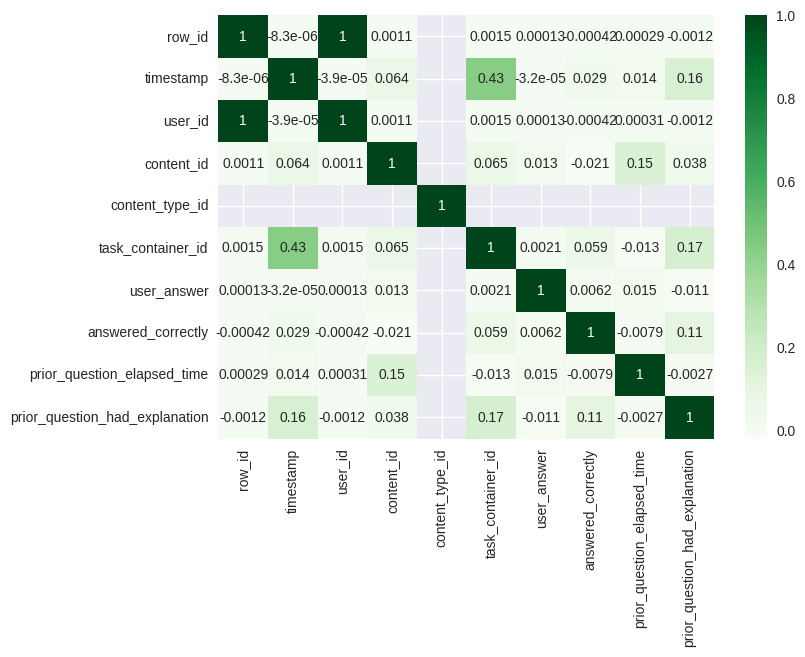

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values, cmap='Greens', annot=True)
plt.show()

Как видите, pyspark позволил справиться с объемом данных, для которого всеми любимого pandas оказалось уже недостаточно. Причем синтаксис pyspark местами очень схож с pandas. А там, где методов чистого pyspark не хватает, на помощь приходит метод pandas_api



## Различные методы инспекции данных
Существуют следующие методы инспекции данных: schema, dtypes, show, head, first, take, describe, columns, count, distinct, printSchema. Давайте разберемся в них на примере.

* `dtypes` возвращает список кортежей с именами столбцов и типами данных.

In [15]:
df.dtypes

[('row_id', 'int'),
 ('timestamp', 'bigint'),
 ('user_id', 'int'),
 ('content_id', 'int'),
 ('content_type_id', 'int'),
 ('task_container_id', 'int'),
 ('user_answer', 'int'),
 ('answered_correctly', 'int'),
 ('prior_question_elapsed_time', 'double'),
 ('prior_question_had_explanation', 'int')]

* `head(n)` возвращает n строк в виде списка. Вот пример:

In [16]:
df.head(5)

[Row(row_id=1, timestamp=56943, user_id=115, content_id=5716, content_type_id=0, task_container_id=2, user_answer=2, answered_correctly=1, prior_question_elapsed_time=37000.0, prior_question_had_explanation=0),
 Row(row_id=2, timestamp=118363, user_id=115, content_id=128, content_type_id=0, task_container_id=0, user_answer=0, answered_correctly=1, prior_question_elapsed_time=55000.0, prior_question_had_explanation=0),
 Row(row_id=3, timestamp=131167, user_id=115, content_id=7860, content_type_id=0, task_container_id=3, user_answer=0, answered_correctly=1, prior_question_elapsed_time=19000.0, prior_question_had_explanation=0),
 Row(row_id=4, timestamp=137965, user_id=115, content_id=7922, content_type_id=0, task_container_id=4, user_answer=1, answered_correctly=1, prior_question_elapsed_time=11000.0, prior_question_had_explanation=0),
 Row(row_id=5, timestamp=157063, user_id=115, content_id=156, content_type_id=0, task_container_id=5, user_answer=2, answered_correctly=1, prior_question_

* `show()` по умолчанию отображает первые 20 строк, а также принимает число в качестве параметра для выбора их количества.
* `first()` возвращает первую строку данных.

In [18]:
df.show()
df.first()

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                             0|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                             0|
|     3|   131167|    115|      7860|              0|                3|          0|                 1|                    19000.0|                             0|
|     4|   137965|    115|  

Row(row_id=1, timestamp=56943, user_id=115, content_id=5716, content_type_id=0, task_container_id=2, user_answer=2, answered_correctly=1, prior_question_elapsed_time=37000.0, prior_question_had_explanation=0)

* `take(n)` возвращает первые n строк.
* `describe()` вычисляет некоторые статистические значения для столбцов с числовым типом данных.
* `columns` возвращает список, содержащий названия столбцов.

In [22]:
df.describe()

DataFrame[summary: string, row_id: string, timestamp: string, user_id: string, content_id: string, content_type_id: string, task_container_id: string, user_answer: string, answered_correctly: string, prior_question_elapsed_time: string, prior_question_had_explanation: string]

In [20]:
df.columns

['row_id',
 'timestamp',
 'user_id',
 'content_id',
 'content_type_id',
 'task_container_id',
 'user_answer',
 'answered_correctly',
 'prior_question_elapsed_time',
 'prior_question_had_explanation']

* `count()` возвращает общее число строк в датасете.

In [23]:
df.count()

98878794

* `distinct()` — количество различных строк в используемом наборе данных.

In [24]:
df.distinct()

DataFrame[row_id: int, timestamp: bigint, user_id: int, content_id: int, content_type_id: int, task_container_id: int, user_answer: int, answered_correctly: int, prior_question_elapsed_time: double, prior_question_had_explanation: int]

## Манипуляции со столбцами
Давайте посмотрим, какие методы используются для добавления, обновления и удаления столбцов данных.

1. Добавление столбца: используйте withColumn, чтобы добавить новый столбец к существующим. Метод принимает два параметра: имя столбца и данные. Пример:

In [26]:
df = df.withColumn('date', df.timestamp)
df.show(5)

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|  date|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+------+
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                             0| 56943|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                             0|118363|
|     3|   131167|    115|      7860|              0|                3|          0|                 1|                    19000.0|                         

2. Обновление столбца: используйте withColumnRenamed, чтобы переименовать существующий столбец. Метод принимает два параметра: название существующего столбца и его новое имя. Пример:

In [27]:
df = df.withColumnRenamed('date', 'data_changed')
df.show()

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|data_changed|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+------------+
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                             0|       56943|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                             0|      118363|
|     3|   131167|    115|      7860|              0|                3|          0|                 1|                    190

3. Удаление столбца: используйте метод drop, который принимает имя столбца и возвращает данные.

In [28]:
df = df.drop('data_changed')
df.show(5)

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                             0|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                             0|
|     3|   131167|    115|      7860|              0|                3|          0|                 1|                    19000.0|                             0|
|     4|   137965|    115|  

## Работа с недостающими значениями
Мы часто сталкиваемся с отсутствующими значениями при работе с данными реального времени. Эти пропущенные значения обозначаются как NaN, пробелы или другие заполнители. Существуют различные методы работы с пропущенными значениями, некоторые из самых популярных:

* Удаление: удалить строки с пропущенными значениями в любом из столбцов.
* Замена средним/медианным значением: замените отсутствующие значения, используя среднее или медиану соответствующего столбца. Это просто, быстро и хорошо работает с небольшими наборами числовых данных.
* Замена на наиболее частые значения: как следует из названия, используйте наиболее часто встречающееся значение в столбце, чтобы заменить отсутствующие. Это хорошо работает с категориальными признаками, но также может вносить смещение (bias) в данные.
* Замена с использованием KNN: метод K-ближайших соседей — это алгоритм классификации, который рассчитывает сходство признаков новых точек данных с уже существующими, используя различные метрики расстояния, такие как Евклидова, Махаланобиса, Манхэттена, Минковского, Хэмминга и другие. Такой подход более точен по сравнению с вышеупомянутыми методами, но он требует больших вычислительных ресурсов и довольно чувствителен к выбросам.

Давайте посмотрим, как мы можем использовать PySpark для решения проблемы отсутствующих значений:

In [ ]:
# Удаление строк с пропущенными значениями
df.na.drop()

# Замена отсутствующих значений средним
df.na.fill(df.select(df.mean(df['user_answer'])).collect()[0][0])

# Замена отсутствующих значений новыми
df.na.replace(old_value, new_vallue)

## Структурирование данных с помощью схемы Spark
Давайте прочитаем данные о ценах на акции в США с января 2019 года по июль 2020 года, которые доступны в [датасетах Kaggle](https://www.kaggle.com/datasets/dinnymathew/usstockprices).

Код для чтения данных в формате файла CSV:

In [45]:
data = spark.read.csv(
    'stocks_price_final.csv',
    sep=',',
    header=True,
)

data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- adjusted: string (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



In [48]:
data.show()

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|_c0|symbol|      date|     open|     high|      low|    close| volume| adjusted|market.cap|       sector|            industry|exchange|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|  1|   TXG|2019-09-12|       54|       58|       51|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  3|   TXG|2019-09-16|52.450001|       56|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  5|   TXG|2019-09-18|56.849998|    62.2

## Получение данных
PySpark и PySpark SQL предоставляют широкий спектр методов и функций для удобного запроса данных. Вот список наиболее часто используемых методов:

* Select
* Filter
* Between
* When
* Like
* GroupBy
* Агрегирование

## Select
Он используется для выбора одного или нескольких столбцов, используя их имена. Вот простой пример:

In [46]:
# Выбор одного столбца
data.select('sector').show(5)

# Выбор нескольких столбцов
data.select(['open', 'close', 'adjusted']).show(5)

+-------------+
|       sector|
+-------------+
|Capital Goods|
|Capital Goods|
|Capital Goods|
|Capital Goods|
|Capital Goods|
+-------------+
only showing top 5 rows

+---------+---------+---------+
|     open|    close| adjusted|
+---------+---------+---------+
|       54|    52.75|    52.75|
|    52.75|    52.27|    52.27|
|52.450001|55.200001|55.200001|
|56.209999|56.779999|56.779999|
|56.849998|       62|       62|
+---------+---------+---------+
only showing top 5 rows



## Filter
Данный метод фильтрует данные на основе заданного условия. Вы также можете указать несколько условий, используя операторы AND (&), OR (|) и NOT (~). Вот пример получения данных о ценах на акции за январь 2020 года.

In [54]:
from pyspark.sql.functions import col, to_date

data.filter((col('date') >= to_date(lit('2020-01-01'))) & (col('date') <= to_date(lit('2020-01-31')))).show(5)



+---+------+----------+---------+---------+---------+---------+------+---------+----------+-------------+--------------------+--------+
|_c0|symbol|      date|     open|     high|      low|    close|volume| adjusted|market.cap|       sector|            industry|exchange|
+---+------+----------+---------+---------+---------+---------+------+---------+----------+-------------+--------------------+--------+
| 78|   TXG|2020-01-02|76.910004|77.989998|71.480003|72.830002|220200|72.830002|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 79|   TXG|2020-01-03|71.519997|76.188004|70.580002|75.559998|288300|75.559998|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 80|   TXG|2020-01-06|75.269997|77.349998|73.559998|75.550003|220600|75.550003|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 81|   TXG|2020-01-07|       76|77.279999|    75.32|75.980003|182400|75.980003|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 82|   TXG|2020-01-08|76.089996|76.949997|72.73

## Between
Этот метод возвращает `True`, если проверяемое значение принадлежит указанному отрезку, иначе — `False`. Давайте посмотрим на пример отбора данных, в которых значения `adjusted` находятся в диапазоне от 100 до 500

In [55]:
data.filter(data.adjusted.between(100.0, 500.0)).show()

+----+------+----------+----------+----------+----------+----------+------+----------+----------+-------------+--------------------+--------+
| _c0|symbol|      date|      open|      high|       low|     close|volume|  adjusted|market.cap|       sector|            industry|exchange|
+----+------+----------+----------+----------+----------+----------+------+----------+----------+-------------+--------------------+--------+
|  93|   TXG|2020-01-24| 95.459999|       101| 94.157997|100.790001|328100|100.790001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  94|   TXG|2020-01-27| 99.760002|104.892998| 97.019997|103.209999|334900|103.209999|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  95|   TXG|2020-01-28|104.620003|108.269997|103.297997|106.620003|245400|106.620003|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|6893|  ABMD|2019-01-02|315.940002|320.709991|307.029999|309.959991|590000|309.959991|   $13.39B|  Health Care|Medical/Dental In...|  NASDAQ|
|6894|

## When
Он возвращает 0 или 1 в зависимости от заданного условия. В приведенном ниже примере показано, как выбрать такие цены на момент открытия и закрытия торгов, при которых скорректированная цена была больше или равна 200.

In [57]:
from pyspark.sql import functions as F

data.select('open', 'close',
            F.when(data.adjusted >= 200.0, 1).otherwise(0)
).show(5)


+---------+---------+-----------------------------------------------+
|     open|    close|CASE WHEN (adjusted >= 200.0) THEN 1 ELSE 0 END|
+---------+---------+-----------------------------------------------+
|       54|    52.75|                                              0|
|    52.75|    52.27|                                              0|
|52.450001|55.200001|                                              0|
|56.209999|56.779999|                                              0|
|56.849998|       62|                                              0|
+---------+---------+-----------------------------------------------+
only showing top 5 rows



## Like
Этот метод похож на оператор Like в SQL. Приведенный ниже код демонстрирует использование `rlike()` для извлечения имен секторов, которые начинаются с букв M или C.

In [58]:
data.select(
    'sector',
    data.sector.rlike('^[B,C]').alias('Колонка sector начинается с B или C')
).distinct().show()


+--------------------+-----------------------------------+
|              sector|Колонка sector начинается с B или C|
+--------------------+-----------------------------------+
|         Health Care|                              false|
|       Capital Goods|                               true|
|Consumer Non-Dura...|                               true|
|    Public Utilities|                              false|
|             Finance|                              false|
|      Transportation|                              false|
|       Miscellaneous|                              false|
|   Consumer Services|                               true|
|              Energy|                              false|
|    Basic Industries|                               true|
|          Technology|                              false|
|   Consumer Durables|                               true|
+--------------------+-----------------------------------+



## GroupBy
Само название подсказывает, что данная функция группирует данные по выбранному столбцу и выполняет различные операции, такие как вычисление суммы, среднего, минимального, максимального значения и т. д. В приведенном ниже примере объясняется, как получить среднюю цену открытия, закрытия и скорректированную цену акций по отраслям.

In [59]:
data.select(['industry', 'open', 'close', 'adjusted'])\
    .groupBy('industry')\
    .mean()\
    .show()

+--------------------+
|            industry|
+--------------------+
|Finance/Investors...|
|Biotechnology: Bi...|
|Other Specialty S...|
|Other Consumer Se...|
|        Water Supply|
|               Banks|
|Farming/Seeds/Mil...|
|Medical/Nursing S...|
|Biotechnology: La...|
|Medical Specialities|
|Computer Software...|
|Biotechnology: In...|
|    Power Generation|
|Property-Casualty...|
|Real Estate Inves...|
|Office Equipment/...|
|Radio And Televis...|
|     Major Chemicals|
|Telecommunication...|
|           Aerospace|
+--------------------+
only showing top 20 rows



## Агрегирование
PySpark предоставляет встроенные стандартные функции агрегации, определенные в API DataFrame, они могут пригодится, когда нам нужно выполнить агрегирование значений ваших столбцов. Другими словами, такие функции работают с группами строк и вычисляют единственное возвращаемое значение для каждой группы.

В приведенном ниже примере показано, как отобразить минимальные, максимальные и средние значения цен открытия, закрытия и скорректированных цен акций в промежутке с января 2019 года по январь 2020 года для каждого сектора.

In [61]:
from pyspark.sql import functions as f

data.filter((col('date') >= lit('2019-01-02')) & (col('date') <= lit('2020-01-31')))\
    .groupBy("sector") \
    .agg(f.min("date").alias("С"),
         f.max("date").alias("По"),

         f.min("open").alias("Минимум при открытии"),
         f.max("open").alias("Максимум при открытии"),
         f.avg("open").alias("Среднее в open"),

         f.min("close").alias("Минимум при закрытии"),
         f.max("close").alias("Максимум при закрытии"),
         f.avg("close").alias("Среднее в close"),

         f.min("adjusted").alias("Скорректированный минимум"),
         f.max("adjusted").alias("Скорректированный максимум"),
         f.avg("adjusted").alias("Среднее в adjusted"),

      ).show(truncate=False)

+---------------------+----------+----------+--------------------+---------------------+------------------+--------------------+---------------------+------------------+-------------------------+--------------------------+------------------+
|sector               |С         |По        |Минимум при открытии|Максимум при открытии|Среднее в open    |Минимум при закрытии|Максимум при закрытии|Среднее в close   |Скорректированный минимум|Скорректированный максимум|Среднее в adjusted|
+---------------------+----------+----------+--------------------+---------------------+------------------+--------------------+---------------------+------------------+-------------------------+--------------------------+------------------+
|Basic Industries     |2019-01-02|2020-01-31|0.61                |99.610001            |22.54558176129424 |0.625               |99.769997            |22.560210586691085|0.625                    |99.769997                 |22.44183949450549 |
|Capital Goods        |2019-01-0

## Запись/сохранение данных в файл
Метод `write.save()` используется для сохранения данных в различных форматах, таких как CSV, JSVON, Parquet и других. Давайте рассмотрим, как записать данные в файлы разных форматов. Мы можем сохранить как все строки, так и только выбранные с помощью метода `select()`.

In [ ]:
# CSV
data.write.csv('dataset.csv')

# JSON
data.write.save('dataset.json', format='json')

# Parquet
data.write.save('dataset.parquet', format='parquet')

# Запись выбранных данных в различные форматы файлов

# CSV
data.select(['data', 'open', 'close', 'adjusted'])\
    .write.csv('dataset.csv')

# JSON
data.select(['data', 'open', 'close', 'adjusted'])\
    .write.save('dataset.json', format='json')

# Parquet
data.select(['data', 'open', 'close', 'adjusted'])\
    .write.save('dataset.parquet', format='parquet')